# Setup and data import

In [20]:
# This tells matplotlib not to try opening a new window for 
# each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import string
import csv
import datetime
import pandas_ml as pdml
from time import time

# SK-learn libraries for learning.
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_mldata
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import GaussianNB
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

# SK-learn libraries for evaluation.
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import *

from pandas_ml import ConfusionMatrix

from pprint import pprint

from textblob import TextBlob

from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.ensemble import VotingClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import Perceptron
from sklearn.neighbors import NearestCentroid
from sklearn.feature_selection import SelectFromModel

Import data

In [18]:
df = pd.read_csv("../Data/news_tweets_big.csv", index_col=0)
df['category'] = pd.factorize(df.category)[0]
clean_df = pd.DataFrame(df,columns=['tweet_text'])
clean_df['target'] = df.category

In [19]:
df.head()

,tweet_text,category
0,"Louisville signee Donovan Mitchell's shoot 3, ...",0
1,"Man, 45, stabs cousin in buttocks during fight...",0
2,City Club forum for Ohio Supreme Court candida...,0
3,Ocean Springs wide receiver Austin Williams ge...,0
4,180 Duarte occupants must evacuate homes in fa...,0


Split data

In [3]:
my_df = clean_df
x = my_df.tweet_text
y = my_df.target
SEED = 2019

x_train, x_dev_and_test, y_train, y_dev_and_test = train_test_split(x, y, test_size=0.4, random_state=SEED)
x_dev, x_test, y_dev, y_test = train_test_split(x_dev_and_test, y_dev_and_test, test_size=0.5, random_state=SEED)
targets = ['troll', 'msnbc']

print('training data shape:', x_train.shape)
print('development data shape:', x_dev.shape)
print('test data shape:', x_test.shape)
print('labels names:', targets)

training data shape: (122413,)
development data shape: (40804,)
test data shape: (40805,)
labels names: ['troll', 'msnbc']


# ML pipeline design

## Basic test (`MultinomialNB`)

In [21]:
pipeline = Pipeline([('tfidf', TfidfVectorizer()),
                     ('clf', MultinomialNB())])

grid = {'tfidf__max_df': [0.5, 0.75, 1.0],
        'tfidf__max_features': np.arange(10000,100001,10000),
        'tfidf__stop_words': [None],
        'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
        'tfidf__use_idf': [True, False],
        'tfidf__norm': ['l1', 'l2'],
        'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
        'clf__alpha': [0.001, 0.01, 0.1, 1]}

scoring = ['accuracy', 'recall', 'precision', 'f1']
grid_search = GridSearchCV(pipeline, grid, cv=5, n_jobs=3, verbose=1,
                          scoring=scoring, refit='accuracy')
grid_search.fit(x_train, y_train)

Fitting 5 folds for each of 1440 candidates, totalling 7200 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


KeyboardInterrupt: 

## Pipeline function (no PCA)

Define function

In [94]:
def clf_pipeline(clf, max_score, full_grid=None, clf_grid=None, pca_components=None):
    # Define pipeline
    pipeline = Pipeline([('tfidf', TfidfVectorizer()),
                         ('clf', clf)])
    
    # Create full grid (if not passed)
    if full_grid is None:
        transf_grid = {'tfidf__max_df': [0.5, 0.75, 1.0],
                       'tfidf__max_features': np.arange(10000,100001,10000),
                       'tfidf__stop_words': [None],
                       'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
                       'tfidf__use_idf': [True, False],
                       'tfidf__norm': [None, 'l1', 'l2'],
                       'clf__alpha': [0.001, 0.01, 0.1, 1]}
        full_grid = {**transf_grid, **clf_grid}
    
    # Fit GridSearch and return resulting object
    scoring = ['accuracy', 'recall', 'precision', 'f1']
    grid_search = GridSearchCV(pipeline, full_grid, cv=5, n_jobs=3, verbose=1,
                              scoring=scoring, refit=max_score)
    grid_search.fit(x_train, y_train)
    
    # Print best results
    print("Best {0}: {1:.3f}".format(max_score, grid_search.best_score_))
    print("\nBest parameters:")
    for param_name in grid_search.best_params_.keys():
        print('{0}: {1}'.format(param_name, grid_search.best_params_[param_name]))
    
    return grid_search

Test function (compare to 8.1)

In [87]:
grid = {'tfidf__max_df': [1.0],
        'tfidf__max_features': [10000],
        'tfidf__stop_words': [None],
        'tfidf__ngram_range': [(1, 1)],
        'tfidf__use_idf': [False],
        'tfidf__norm': [None],
        'clf__penalty': ['l2'],
        'clf__solver': ['liblinear'],
        'clf__C': [1]}

clf_gs = clf_pipeline(clf=LogisticRegression(), full_grid=grid, max_score='accuracy')

# Results with dev set
pred_dev = clf_gs.predict(x_dev)
acc_dev = metrics.accuracy_score(y_dev, pred_dev)
print('\nAccuracy (dev set) = {:.4f}'.format(acc_dev))

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:   30.0s finished


Best accuracy: 0.903

Best parameters:
clf__C: 1
clf__penalty: l2
clf__solver: liblinear
tfidf__max_df: 1.0
tfidf__max_features: 10000
tfidf__ngram_range: (1, 1)
tfidf__norm: None
tfidf__stop_words: None
tfidf__use_idf: False

Accuracy (dev set) = 0.9017


## Pipeline function (Dimensionality reduction)

Dimensionality reduction analysis

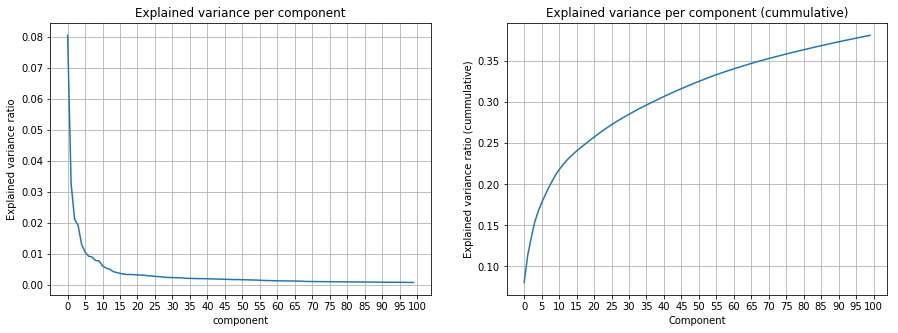

In [24]:
# Fit 100 first components
x_train_vect = CountVectorizer().fit_transform(x_train)
dim_reductor = TruncatedSVD(n_components=100).fit(x_train_vect)
x_train_dimred = dim_reductor.transform(x_train_vect)
explained = dim_reductor.explained_variance_ratio_

# Create figure with two plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot explained variance ratio
ax1.plot([i for i in range(100)], explained)
ax1.set_title("Explained variance per component")
ax1.set_xticks(range(0, 101, 5));
ax1.set_xlabel("component")
ax1.set_ylabel("Explained variance ratio")
ax1.grid(axis='x');
ax1.grid(axis='y');

# Plot cummulative explained variance ratio 
ax2.plot([i for i in range(100)], np.cumsum(explained))
ax2.set_title("Explained variance per component (cummulative)")
ax2.set_xticks(range(0, 101, 5));
ax2.set_xlabel("Component")
ax2.set_ylabel("Explained variance ratio (cummulative)")
ax2.grid(axis='x');
ax2.grid(axis='y');

Define function

In [108]:
def pca_clf_pipeline(clf, max_score, full_grid=None, clf_grid=None, pca_components=None):
    # Define pipeline
    pipeline = Pipeline([('tfidf', TfidfVectorizer()),
                         ('dim_red', TruncatedSVD(random_state=123)),
                         ('clf', clf)])
    
    # Create full grid (if not passed)
    if full_grid is None:
        transf_grid = {'tfidf__max_df': [0.5, 0.75, 1.0],
                       'tfidf__max_features': np.arange(10000,100001,10000),
                       'tfidf__stop_words': [None],
                       'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
                       'tfidf__use_idf': [True, False],
                       'tfidf__norm': [None, 'l1', 'l2'],
                       'dim_red__n_components': [2],
                       'clf__alpha': [0.001, 0.01, 0.1, 1]}
        full_grid = {**transf_grid, **clf_grid}
    
    # Fit GridSearch and return resulting object
    scoring = ['accuracy', 'recall', 'precision', 'f1']
    grid_search = GridSearchCV(pipeline, full_grid, cv=5, n_jobs=3, verbose=1,
                              scoring=scoring, refit=max_score)
    grid_search.fit(x_train, y_train)    
    
    # Print best results
    print("Best {0}: {1:.3f}".format(max_score, grid_search.best_score_))
    print("\nBest parameters:")
    for param_name in grid_search.best_params_.keys():
        print('{0}: {1}'.format(param_name, grid_search.best_params_[param_name]))
        
    return grid_search

Test with `n_components`=1,000

In [104]:
grid = {'tfidf__max_df': [1.0],
        'tfidf__max_features': [10000],
        'tfidf__stop_words': [None],
        'tfidf__ngram_range': [(1, 1)],
        'tfidf__use_idf': [False],
        'tfidf__norm': [None],
        'dim_red__n_components': [1000],
        'clf__penalty': ['l2'],
        'clf__solver': ['liblinear'],
        'clf__C': [1]}

clf_gs = pca_clf_pipeline(clf=LogisticRegression(), full_grid=grid, max_score='accuracy')

# Results with dev set
pred_dev = clf_gs.predict(x_dev)
acc_dev = metrics.accuracy_score(y_dev, pred_dev)
print('\nAccuracy (dev set) = {:.4f}'.format(acc_dev))

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed: 15.7min finished


Best accuracy: 0.885

Best parameters:
clf__C: 1
clf__penalty: l2
clf__solver: liblinear
pca__n_components: 1000
tfidf__max_df: 1.0
tfidf__max_features: 10000
tfidf__ngram_range: (1, 1)
tfidf__norm: None
tfidf__stop_words: None
tfidf__use_idf: False

Accuracy (dev set) = 0.8840


Test with and without dimensionality reduction

In [131]:
grid = {'tfidf__max_df': [1.0],
        'tfidf__max_features': [10000],
        'tfidf__stop_words': [None],
        'tfidf__ngram_range': [(1, 1)],
        'tfidf__use_idf': [False],
        'tfidf__norm': [None],
        'dim_red': [None, TruncatedSVD(30, random_state=123)],
        'clf__penalty': ['l2'],
        'clf__solver': ['liblinear'],
        'clf__C': [1]}

clf_gs = pca_clf_pipeline(clf=LogisticRegression(), full_grid=grid, max_score='accuracy')

# Results with dev set
pred_dev = clf_gs.predict(x_dev)
acc_dev = metrics.accuracy_score(y_dev, pred_dev)
print('\nAccuracy (dev set) = {:.4f}'.format(acc_dev))

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:  1.1min finished


Best accuracy: 0.903

Best parameters:
clf__C: 1
clf__penalty: l2
clf__solver: liblinear
dim_red: None
tfidf__max_df: 1.0
tfidf__max_features: 10000
tfidf__ngram_range: (1, 1)
tfidf__norm: None
tfidf__stop_words: None
tfidf__use_idf: False

Accuracy (dev set) = 0.9017


# ML Pipeline

Define function

In [4]:
def grid_search(train_data, train_labels, clf, grid, max_score):
    # Define pipeline
    pipeline = Pipeline([('tfidf', TfidfVectorizer()),
                         ('dim_red', TruncatedSVD(random_state=123)),
                         ('clf', clf)])
    
    # Fit GridSearch and return resulting object
    scoring = ['accuracy', 'recall', 'precision', 'f1']
    grid_search = GridSearchCV(pipeline, grid, cv=5, n_jobs=3, verbose=1,
                              scoring=scoring, refit=max_score)
    grid_search.fit(train_data, train_labels)    
    
    # Print best results
    print("Best {0}: {1:.3f}".format(max_score, grid_search.best_score_))
    print("\nBest parameters:")
    for param_name in grid_search.best_params_.keys():
        print('{0}: {1}'.format(param_name, grid_search.best_params_[param_name]))
        
    return grid_search

Find best parameters for logistic regression

In [8]:
grid = {'tfidf__max_df': np.arange(0, 1.01, 0.25) ,
        'tfidf__max_features': np.arange(10000,100001,10000),
        'tfidf__stop_words': [None, 'english'],
        'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
        'tfidf__use_idf': [False, True],
        'tfidf__norm': [None, 'l1', 'l2'],
        'dim_red': [None, TruncatedSVD(30, random_state=123)],
        'clf__penalty': ['l1', 'l2'],
        'clf__solver': ['saga'],
        'clf__C': [0.0001, 0.01, 0.1, 1, 10, 100]}

clf_gs = grid_search(x_train, y_train, LogisticRegression(), grid, 'accuracy')

# Results with dev set
pred_dev = clf_gs.predict(x_dev)
acc_dev = metrics.accuracy_score(y_dev, pred_dev)
print('\nAccuracy (dev set) = {:.4f}'.format(acc_dev))

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:   27.6s finished


Best accuracy: 0.903

Best parameters:
clf__C: 1
clf__penalty: l2
clf__solver: liblinear
dim_red: None
tfidf__max_df: 1.0
tfidf__max_features: 10000
tfidf__ngram_range: (1, 1)
tfidf__norm: None
tfidf__stop_words: None
tfidf__use_idf: False

Accuracy (dev set) = 0.9017


### Questions
 1. Do we need dev set?